В этом ноутбуке:

* Преобработка данных
* Данные обрезаются до 100000
* Предсттавление текста tf-idf

На обрезанных данных пробуются разные алгоритмы с целью выявить лучшие для всего объёма данных:

* MultinomialNB
* ComplementNB
* BernoulliNB
* LogisticRegression
* SVC
* LinearSVC
* Random Forest

Тюнинг алгоритмов проводится с помощью распараллеливания кросс-валидации через dask

Ссылка на данные https://www.kaggle.com/kazanova/sentiment140

# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка и предобработка данных

In [2]:
# загрузка
df = pd.read_csv('training.1600000.processed.noemoticon.csv',names=['target', 'id', 'date', 'flag', 'user', 'text'],
                 encoding='latin-1')

# отображение
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# кол-во данных в датасете
len(df)

1600000

## Удалим все признаки кроме target и text

Задача в прогнозировании метки target на основе текстового описания (признак text), остальные признаки неинформативны.

In [4]:
# удаление неинформативных признаков
df = df.drop(['id', 'date', 'flag', 'user'], axis = 1)

df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Проверим на наличие null значений и дропнем их, если присутсвуют

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Все строки заполнены, null значения отсутсвуют

## Посмотрим на балансировку целевой величины

In [6]:
df.groupby('target')['target'].count()


target
0    800000
4    800000
Name: target, dtype: int64

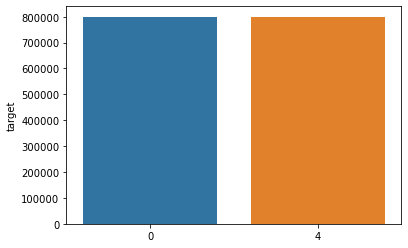

In [7]:
balance = df.groupby('target')['target'].count()

sns.barplot(x = [0, 4], y = balance)

The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive)

По заданию классификация на три класса, однако класс 2 = neutral полностью отсутсвует. Переходим к задаче бинарной классификации: (0 = negative, 4 = positive)

Для задачи бинарной классификации данные идеально сбалансированны (50 на 50).

## Преобразуем метку 4 в метку 1 для удобства (будем классифицировать 0 и 1)

In [8]:
df['target'][df['target'] == 4] = 1

D:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df.groupby('target')['target'].count()

target
0    800000
1    800000
Name: target, dtype: int64

In [10]:
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


# Обрежем датасет до 100000 значений, чтобы потом выбрать лучшие алгоритмы

## Обрезка

Данные не перемешаны, так что сделаем несколько шафлов

In [11]:
# перемешаем 5 раз

for i in range(5):
    df = df.sample(frac=1).reset_index(drop=True)

df.head()

,target,text
0,1,@OhSweetNibblets btw they have accepted you
1,1,is the Birthday Girl
2,1,I'm so excited. Started writing again today a...
3,1,@dan99iel subscribe as in RSS by the way.
4,0,Ugh im in the middle of nowhere! And i still h...


In [12]:
# обрежем до 100000 значений

df_cut = df[:100000]

len(df_cut)

100000

## Ещё раз посмотрим на баланс целевой величины

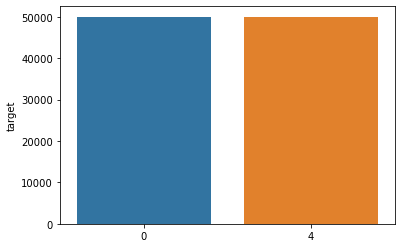

In [13]:
balance = df_cut.groupby('target')['target'].count()

sns.barplot(x = [0, 4], y = balance)

In [14]:
df_cut.groupby('target')['target'].count()

target
0    49960
1    50040
Name: target, dtype: int64

Баланс примерно остался 50 на 50

## Представим text через tf-idf

In [15]:
# выделим text в отдельную переменную

text_frame = df_cut['text'].copy()
text_frame

0             @OhSweetNibblets btw they have accepted you 
1                                    is the Birthday Girl 
2        I'm so excited. Started writing again today  a...
3               @dan99iel subscribe as in RSS by the way. 
4        Ugh im in the middle of nowhere! And i still h...
                               ...                        
99995    http://twitpic.com/6aijy - yeah you can see my...
99996    @fudgethefacts thanks Renee - have been fighti...
99997                    I wish today was like yesterday. 
99998    weird things happen when u wake up before noon...
99999    @LynneHutcheson yeh!hahaha. theyr all to sweet...
Name: text, Length: 100000, dtype: object

In [16]:
# импортируем tfidf преобразование
from sklearn.feature_extraction.text import TfidfVectorizer

# стоп слова
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# инициализировали алгоритм
vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))

# преобразовали в матрицу tfidf 
text_tfidf = vectorizer.fit_transform(text_frame.values)

# отобразим значения 

text_tfidf[0]

D:\conda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


<1x544032 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

## Выделим целевую переменную

In [17]:
y = np.array(df_cut['target'])
y

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

## Cделаем train-test split 

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_tfidf,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

# Обучение алгоритмов на обрезанных данных

## Создадим dask клиент для параллельных вычислений

In [19]:
from dask.distributed import Client
import joblib

client = Client(n_workers=8) 
client

Client Scheduler: tcp://127.0.0.1:57131 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.12 GB


## Алгоритмы Наивного Байеса

### Multinomial Naive Bayes

In [20]:
# модель

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

alg = MultinomialNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float')}

gs = GridSearchCV(alg, grid, verbose=1 ,scoring='f1')

In [21]:
# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.6s finished


In [22]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'alpha': 4.137931034482759}, 0.7487664683760895)

In [23]:
# проверим на тесте

from sklearn.metrics import classification_report

clf = MultinomialNB(alpha=4.137931034482759)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77     10009
           1       0.78      0.73      0.75      9991

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



[[7887 2122]
 [2666 7325]]


Text(0.5, 42.0, 'Predicted value')

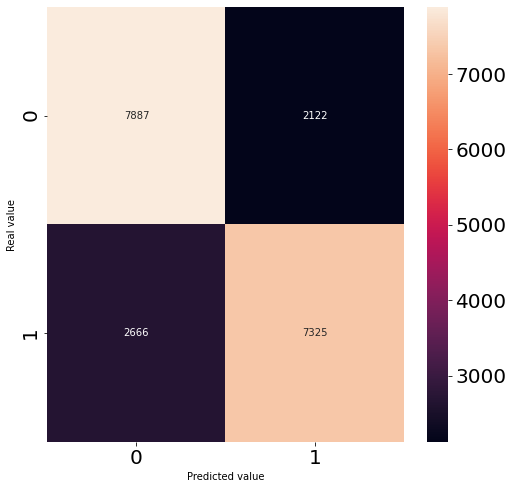

In [24]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Получили хорошие метрики и, что важно, довольно быстро. f1 метрика у негативного класса - 0.77,  Recall у негативного класса 0.79 - это хорошо, посмотрим, можно ли получить лучше.

### Complement Naive Bayes

In [25]:
# модель

from sklearn.naive_bayes import ComplementNB

alg = ComplementNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, scoring='f1')

In [26]:
# рестартнем клиент 

client.restart()

# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.4s finished


In [27]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'alpha': 2.896551724137931}, 0.7453436470148891)

In [28]:
# проверим на тесте

from sklearn.metrics import classification_report

clf = ComplementNB(alpha=2.896551724137931)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     10009
           1       0.78      0.72      0.75      9991

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



[[7979 2030]
 [2754 7237]]


Text(0.5, 42.0, 'Predicted value')

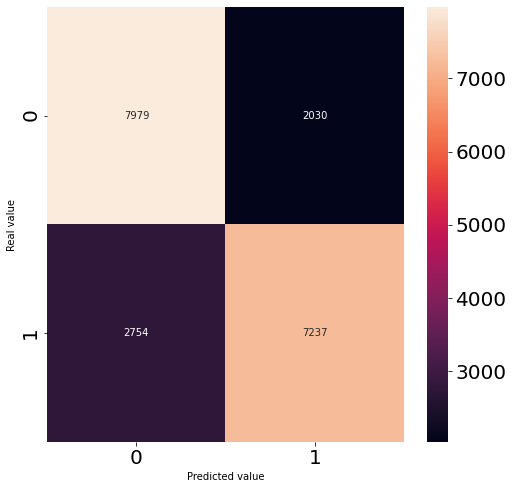

In [29]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Почти одинаковые метрики, но recall негативного класса уже 0.8, f1 метрика такая же - - 0.77. У позитивного recall упал на одну сотую, f1 метрика такая же - 0.75

Из этих двух алгоритмов я бы выбрал ComplementNB, так как, мне кажется,  recall негативного класса важнее

### Bernoulli Naive Bayes

In [31]:
# модель

from sklearn.naive_bayes import BernoulliNB

alg = BernoulliNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, scoring = 'f1')

In [32]:
# рестартнем клиент 

client.restart()

# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.4s finished


In [33]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'alpha': 6.0}, 0.7464870961661537)

In [34]:
# проверим на тесте

from sklearn.metrics import classification_report

clf = BernoulliNB(alpha=6.0)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     10009
           1       0.78      0.72      0.75      9991

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



[[7989 2020]
 [2831 7160]]


Text(0.5, 42.0, 'Predicted value')

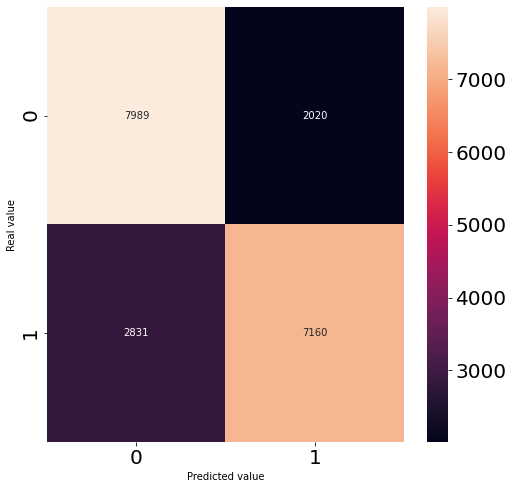

In [35]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Идентичные ComplementNB метрики, но работал BernoulliNB на 2 секунды дольше. Пусть это незначительно, но всё же я выберу из алгоритмов Наивного Байеса ComplementNB для работы с полным датасетом.

В целом для таких простых алгоритмов, алгоритмы Наивного Байеса очень быстро обучились и дали хорошие метрики.

Целесообразно будет опробовать ComplementNB для всего датасета

## Logistic Regression

In [36]:
# модель

from sklearn.linear_model import LogisticRegression

alg = LogisticRegression()

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1,scoring='f1')

In [37]:
# рестартнем клиент 

client.restart()

# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.4min finished


In [38]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'C': 7.742636826811277, 'penalty': 'l2'}, 0.7703600919198182)

In [39]:
# проверим на тесте

clf = LogisticRegression(C= 7.742636826811277,penalty='l2')
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     10009
           1       0.76      0.80      0.78      9991

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



D:\conda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[7484 2525]
 [2038 7953]]


Text(0.5, 42.0, 'Predicted value')

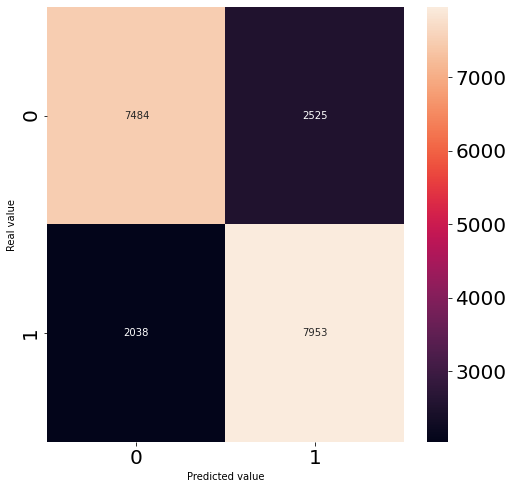

In [40]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Получили recall негативного класса ниже - 0.75, f1-метрика осталась прежней - 0.77, то есть возрос
precision.

Однако, у позитивного класса мы получаем выше recall и выше f1 метрику.

Тут нужно решать, что для нас важнее.

Если отличать негативные от позитивных, то алгоритмы наивного байеса смотрятся лучше.

Если отличать позитивные от негативных, плюс лучше обнаруживать негативные, то лучше логрег

Но в целом у логрега лучше f1 метркики (одна такая же, другая лучше), значит в целом алгоритм сработал точнее

Сравним его с SVM и выберем второй алгортим, который опробуем на всех данных

Так же логрегу нужно добавить итераций


## SVM

In [41]:
# модель

from sklearn.svm import SVC

alg = SVC()

grid = {'C': np.array(np.linspace(-5, 5, 10), dtype='float'),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        }

gs = GridSearchCV(alg, grid, verbose=1, scoring='f1')

In [42]:
# рестартнем клиент 

client.restart()

# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Restarting worker


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
distributed.utils - ERROR - '<' not supported between instances of 'NoneType' and 'tuple'
Traceback (most recent call last):
  File "D:\conda\lib\site-packages\distributed\utils.py", line 656, in log_errors
    yield
  File "D:\conda\lib\site-packages\distributed\dashboard\components\scheduler.py", line 1969, in graph_doc
    graph = TaskGraph(scheduler, sizing_mode="stretch_both")
  File "D:\conda\lib\site-packages\distributed\dashboard\components\scheduler.py", line 1326, in __init__
    self.layout = GraphLayout(scheduler)
  File "D:\conda\lib\site-packages\distributed\diagnostics\graph_layout.py", line 42, in __init__
    priority=priority,
  File "D:\conda\lib\site-packages\distributed\diagnostics\graph_layout.py", line 48, in update_graph
    stack = sorted(tasks, key=lambda k: priority.get(k, 0), reverse=True)
TypeError: '<' not sup

In [43]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'C': 0.5555555555555554, 'kernel': 'linear'}, 0.7735159128327115)

In [44]:
clf = SVC(C=0.5555555555555554, kernel='linear')
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76     10009
           1       0.75      0.81      0.78      9991

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



[[7275 2734]
 [1868 8123]]


Text(0.5, 42.0, 'Predicted value')

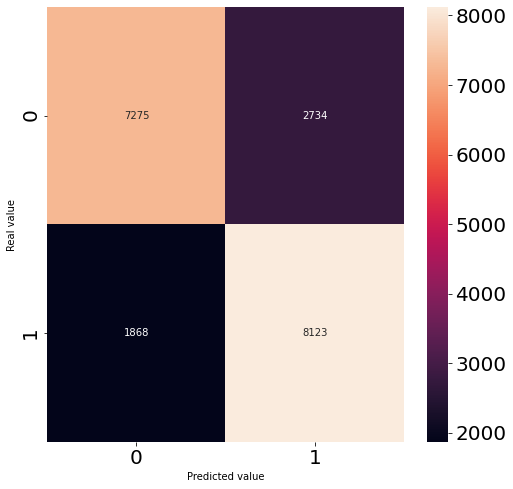

In [45]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

На 100000 значений распаралелленный svm обучался 16 с половиной часов. Значит, на 1600000 значений будет примерно в 16 раз дольше, то есть около 256 часов (10 с половиной суток). 

SVM не лучший алгоритм для работы с таким объемом данных, да ещё и с текстом в tf-idf (слишком большое пространство признаков)

Метрики получились даже немного хуже, чем у логистической регрессии, при этом логрег сработал в 300 раз быстрее на кросс-валидации))))

SVM на полном датасете запускать не буду, пока предпочтение отдаю логистической регрессии

## LinearSVC

Решил так же попробовать алгоритм LinearSVC, так как есть подозрения, что svm так долго работает из-за нелинейных ядер, которые мы перебираем.

Так же на кросс-валидации лучшее ядро для svm оказалось линейное, попробуем настроить его точнее.

In [46]:
# модель

from sklearn.svm import LinearSVC

alg = LinearSVC()

grid = {'C': np.array(np.linspace(0, 5, 10), dtype='float'),
        'penalty': ['l1', 'l2'],
         }

gs = GridSearchCV(alg, grid, verbose=1, scoring='f1')

In [47]:
#рестартнем клиент 

client.restart()

# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.9s finished


In [48]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'C': 0.5555555555555556, 'penalty': 'l2'}, 0.7717382558909353)

In [49]:
clf = LinearSVC(C=0.5555555555555556, penalty='l2')
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77     10009
           1       0.76      0.80      0.78      9991

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



[[7437 2572]
 [1985 8006]]


Text(0.5, 42.0, 'Predicted value')

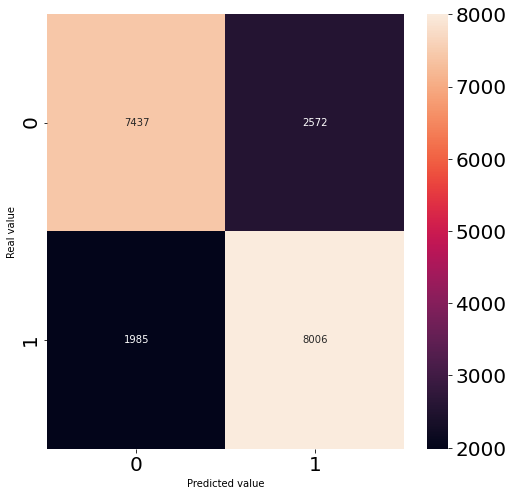

In [50]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Linear SVC сработал даже быстрее лог рега, получились почти такие же метрики.

На полном датасете я хочу попробовать и  Logistic Regression и Linear SVC.

## Random Forest

В прошлом ДЗ RF сработал плохо на тексте, но я решил попробовать ещё раз с лучшим тюнингом

In [53]:
# модель

from sklearn.ensemble import RandomForestClassifier

alg = RandomForestClassifier()

grid = {'min_samples_split': [i for i in range(0, 50, 10)],
               'max_depth': [i for i in range(5, 15, 3)],
               'min_samples_leaf':[i for i in range(2, 4)]
             }
gs = GridSearchCV(alg, grid, verbose=1, scoring='f1')

In [54]:
#рестартнем клиент 

client.restart()

# параллельная кросс-валидация

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Restarting worker


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 23.2min finished


In [55]:
# отобразим лучшие параметры

gs.best_params_, gs.best_score_

({'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 40},
 0.7353310198098688)

In [56]:
clf = RandomForestClassifier(max_depth=14, min_samples_leaf= 3, min_samples_split= 40)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67     10009
           1       0.67      0.81      0.73      9991

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.70     20000
weighted avg       0.72      0.71      0.70     20000



[[6027 3982]
 [1900 8091]]


Text(0.5, 42.0, 'Predicted value')

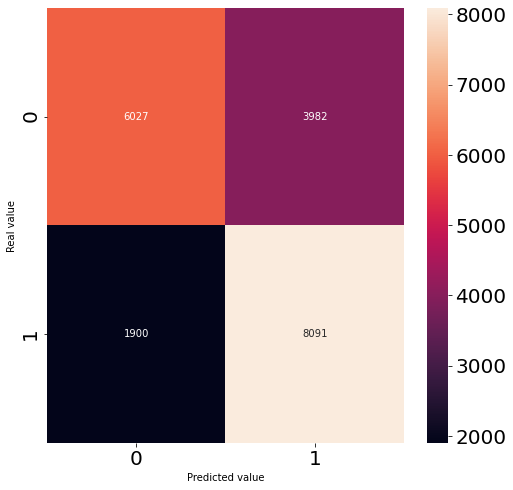

In [57]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Всё таки RF с текстом не очень хорош (слишком большое пр-во признаков)

# Небольшой вывод

На 100к значений я выбрал алгоритмы, которые показали себя лучше всего, их я опробую на полном датасете (1.6кк занчений). Алгоритмы: ComplementNB, BernoulliNB, LogisticRegression, LinearSVC.


Это будет в ноутбуке hw3_fulldata